In [93]:
import os
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import plotly
import plotly.graph_objects as go
import plotly.express as px
import kaleido ##pip install -U kaleido ##to save a plotly fig
import sys 
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import StandardScaler

In [94]:
df1 = pd.read_csv('Stable_Data_CSV.csv')
df2 = pd.read_csv('6wUsingBL.csv')
df_stable = df2[df2.set_index(['participant_id']).index.isin(df1.set_index(['participant_id']).index)]

In [95]:
df_stable_US = df_stable.loc[(df_stable['arm'] == 1)]
df_stable_WN = df_stable.loc[(df_stable['arm'] == 2)]
print(len(df_stable_US))
print(len(df_stable_WN))

31
30


In [102]:
df_stable_US=(df_stable_US[['c_3','sl_1','a_2','q_1','tfi_total.1','tfi_total.2','tfi_total.3']])
df_stable_WN=(df_stable_WN[['sl_2','r_1','e_1','tfi_total.1','tfi_total.2','tfi_total.3']])
#x_test_new_df= pd.DataFrame(columns=['c_3','sl_1','sl_2','a_2','r_1','q_1','e_1','tfi_total.1'])
x_test_new_df=pd.read_csv('new_test_data_6w_12w_1ts.csv')
x_test_new_df

,c_3,sl_1,sl_2,a_2,r_1,q_1,e_1,tfi_total.1
0,4.5,5.0,2.5,5.5,5.5,4.5,5.5,78.9


In [97]:
US_checkpoint_path = "model_checkpoints/6w_12w_1ts/US/cp.ckpt"
WN_checkpoint_path = "model_checkpoints/6w_12w_1ts/WN/cp.ckpt"
lr=0.001
n_epochs=200
n_batch_size=10
n_timesteps=1

def data_prep(df):
    sc_x=StandardScaler()
    sc_y=StandardScaler()
    ## Separate dependent and independent features 
    X=df.drop(['tfi_total.2','tfi_total.3'],axis=1)
    y = df[['tfi_total.2','tfi_total.3']]
    #Train Test Split
    x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
    #scale x
    x_scaler=sc_x.fit(x_train)
    x_train=x_scaler.transform(x_train)
    x_test=x_scaler.transform(x_test)
    #scale y
    y_scaler=sc_y.fit(y_train)
    y_train=y_scaler.transform(y_train)
    y_test=y_scaler.transform(y_test)
    # Reshape input to be 3D for LSTM[samples, timesteps, features]
    x_train = x_train.reshape((x_train.shape[0],n_timesteps,x_train.shape[1]))
    x_test = x_test.reshape((x_test.shape[0],n_timesteps,x_test.shape[1]))
    print(x_train.shape,y_train.shape, x_test.shape, y_test.shape)
    return x_train, x_test, y_train, y_test,x_scaler,y_scaler

def create_lstm_model(input_shape):
    tf.keras.backend.clear_session
    input_shape=input_shape
    model = tf.keras.Sequential([
      tf.keras.layers.LSTM(50, activation='relu',input_shape=input_shape),
      tf.keras.layers.Dropout(0.2), # 20% of Neuron will get deactivated during training
      tf.keras.layers.Dense(2,activation = 'linear')                      
    ])             

    model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
    return model

def train_model(df,ck_path):
    x_train, x_test, y_train, y_test,x_scaler,y_scaler= data_prep(df)
    input_shape=(n_timesteps,x_train.shape[2])
    print(input_shape)
    model = create_lstm_model(input_shape)  # Create a basic model instance
    model.summary() # Display the model's architecture
    # Create a callback that saves the model's weights #save_best_only=True  (to save model)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ck_path, save_weights_only=True,verbose=1)
    # Train the model
    history = model.fit(x_train, y_train, epochs=n_epochs, batch_size=n_batch_size, validation_data=(x_test, y_test),callbacks=[cp_callback], verbose=1, shuffle=False)
    return history,x_scaler,y_scaler

#train lstm_model for US data and WN data seperately
US_history,US_x_scaler,US_y_scaler=train_model(df_stable_US,US_checkpoint_path)
WN_history,WN_x_scaler,WN_y_scaler=train_model(df_stable_WN,WN_checkpoint_path)

(24, 1, 5) (24, 2) (7, 1, 5) (7, 2)
(1, 5)
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 50)                11200     
                                                                 
 dropout_60 (Dropout)        (None, 50)                0         
                                                                 
 dense_60 (Dense)            (None, 2)                 102       
                                                                 
Total params: 11,302
Trainable params: 11,302
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


2022-05-15 06:15:23.616379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 0.8693
Epoch 1: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 1s 92ms/step - loss: 0.8693 - val_loss: 1.0686
Epoch 2/200
1/3 [=========>....................] - ETA: 0s - loss: 0.8948
Epoch 2: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 27ms/step - loss: 0.8645 - val_loss: 1.0653
Epoch 3/200
1/3 [=========>....................] - ETA: 0s - loss: 0.8925
Epoch 3: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.8609 - val_loss: 1.0625
Epoch 4/200


2022-05-15 06:15:23.947823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 0s - loss: 0.8906
Epoch 4: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 25ms/step - loss: 0.8574 - val_loss: 1.0599
Epoch 5/200
1/3 [=========>....................] - ETA: 0s - loss: 0.8890
Epoch 5: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 26ms/step - loss: 0.8540 - val_loss: 1.0574
Epoch 6/200
1/3 [=========>....................] - ETA: 0s - loss: 0.8874
Epoch 6: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 26ms/step - loss: 0.8507 - val_loss: 1.0551
Epoch 7/200
1/3 [=========>....................] - ETA: 0s - loss: 0.8860
Epoch 7: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 25ms/step - loss: 0.8474 - val_loss: 1.0529
Epoch 8/200
1/3 [=========>....................] - ETA: 0s - loss: 0.8846
Epoch 8: saving model to model_checkpo

1/3 [=========>....................] - ETA: 0s - loss: 0.8420
Epoch 40: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.6989 - val_loss: 0.9517
Epoch 41/200
1/3 [=========>....................] - ETA: 0s - loss: 0.8401
Epoch 41: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.6924 - val_loss: 0.9476
Epoch 42/200
1/3 [=========>....................] - ETA: 0s - loss: 0.8382
Epoch 42: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.6858 - val_loss: 0.9436
Epoch 43/200
1/3 [=========>....................] - ETA: 0s - loss: 0.8362
Epoch 43: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.6789 - val_loss: 0.9395
Epoch 44/200
1/3 [=========>....................] - ETA: 0s - loss: 0.8342
Epoch 44: saving model to mode

1/3 [=========>....................] - ETA: 0s - loss: 0.7348
Epoch 76: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.5268 - val_loss: 0.8714
Epoch 77/200
1/3 [=========>....................] - ETA: 0s - loss: 0.7300
Epoch 77: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.5227 - val_loss: 0.8732
Epoch 78/200
1/3 [=========>....................] - ETA: 0s - loss: 0.7258
Epoch 78: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.5192 - val_loss: 0.8754
Epoch 79/200
1/3 [=========>....................] - ETA: 0s - loss: 0.7222
Epoch 79: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.5152 - val_loss: 0.8775
Epoch 80/200
1/3 [=========>....................] - ETA: 0s - loss: 0.7186
Epoch 80: saving model to mode

1/3 [=========>....................] - ETA: 0s - loss: 0.5802
Epoch 112: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.4018 - val_loss: 0.8521
Epoch 113/200
1/3 [=========>....................] - ETA: 0s - loss: 0.5776
Epoch 113: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.3997 - val_loss: 0.8489
Epoch 114/200
1/3 [=========>....................] - ETA: 0s - loss: 0.5726
Epoch 114: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.3957 - val_loss: 0.8478
Epoch 115/200
1/3 [=========>....................] - ETA: 0s - loss: 0.5690
Epoch 115: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.3925 - val_loss: 0.8460
Epoch 116/200
1/3 [=========>....................] - ETA: 0s - loss: 0.5634
Epoch 116: saving mode

Epoch 148/200
1/3 [=========>....................] - ETA: 0s - loss: 0.4361
Epoch 148: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.2981 - val_loss: 0.7854
Epoch 149/200
1/3 [=========>....................] - ETA: 0s - loss: 0.4319
Epoch 149: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.2964 - val_loss: 0.7851
Epoch 150/200
1/3 [=========>....................] - ETA: 0s - loss: 0.4289
Epoch 150: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.2942 - val_loss: 0.7822
Epoch 151/200
1/3 [=========>....................] - ETA: 0s - loss: 0.4247
Epoch 151: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.2912 - val_loss: 0.7771
Epoch 152/200
1/3 [=========>....................] - ETA: 0s - loss: 0.4238
Epoch 15

Epoch 184/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3337
Epoch 184: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.2273 - val_loss: 0.7454
Epoch 185/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3312
Epoch 185: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.2263 - val_loss: 0.7497
Epoch 186/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3302
Epoch 186: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.2249 - val_loss: 0.7501
Epoch 187/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3272
Epoch 187: saving model to model_checkpoints/6w_12w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.2236 - val_loss: 0.7495
Epoch 188/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3233
Epoch 18

2022-05-15 06:15:36.345584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 1s 91ms/step - loss: 0.8811 - val_loss: 0.5620
Epoch 2/200
1/3 [=========>....................] - ETA: 0s - loss: 0.9334
Epoch 2: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 26ms/step - loss: 0.8742 - val_loss: 0.5606
Epoch 3/200
1/3 [=========>....................] - ETA: 0s - loss: 0.9268
Epoch 3: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 25ms/step - loss: 0.8681 - val_loss: 0.5595
Epoch 4/200


2022-05-15 06:15:36.653774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 0s - loss: 0.9204
Epoch 4: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 25ms/step - loss: 0.8620 - val_loss: 0.5587
Epoch 5/200
1/3 [=========>....................] - ETA: 0s - loss: 0.9142
Epoch 5: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 26ms/step - loss: 0.8561 - val_loss: 0.5579
Epoch 6/200
1/3 [=========>....................] - ETA: 0s - loss: 0.9080
Epoch 6: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.8502 - val_loss: 0.5571
Epoch 7/200
1/3 [=========>....................] - ETA: 0s - loss: 0.9018
Epoch 7: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.8443 - val_loss: 0.5563
Epoch 8/200
1/3 [=========>....................] - ETA: 0s - loss: 0.8956
Epoch 8: saving model to model_checkpo

1/3 [=========>....................] - ETA: 0s - loss: 0.7144
Epoch 40: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.6813 - val_loss: 0.5271
Epoch 41/200
1/3 [=========>....................] - ETA: 0s - loss: 0.7119
Epoch 41: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 25ms/step - loss: 0.6778 - val_loss: 0.5258
Epoch 42/200
1/3 [=========>....................] - ETA: 0s - loss: 0.7093
Epoch 42: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.6745 - val_loss: 0.5244
Epoch 43/200
1/3 [=========>....................] - ETA: 0s - loss: 0.7064
Epoch 43: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.6708 - val_loss: 0.5225
Epoch 44/200
1/3 [=========>....................] - ETA: 0s - loss: 0.7034
Epoch 44: saving model to mode

1/3 [=========>....................] - ETA: 0s - loss: 0.6178
Epoch 76: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.5632 - val_loss: 0.4515
Epoch 77/200
1/3 [=========>....................] - ETA: 0s - loss: 0.6149
Epoch 77: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.5614 - val_loss: 0.4507
Epoch 78/200
1/3 [=========>....................] - ETA: 0s - loss: 0.6123
Epoch 78: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.5592 - val_loss: 0.4498
Epoch 79/200
1/3 [=========>....................] - ETA: 0s - loss: 0.6100
Epoch 79: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.5575 - val_loss: 0.4496
Epoch 80/200
1/3 [=========>....................] - ETA: 0s - loss: 0.6081
Epoch 80: saving model to mode

1/3 [=========>....................] - ETA: 0s - loss: 0.5079
Epoch 112: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.4834 - val_loss: 0.4419
Epoch 113/200
1/3 [=========>....................] - ETA: 0s - loss: 0.5032
Epoch 113: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.4793 - val_loss: 0.4411
Epoch 114/200
1/3 [=========>....................] - ETA: 0s - loss: 0.4991
Epoch 114: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.4772 - val_loss: 0.4409
Epoch 115/200
1/3 [=========>....................] - ETA: 0s - loss: 0.4953
Epoch 115: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.4745 - val_loss: 0.4405
Epoch 116/200
1/3 [=========>....................] - ETA: 0s - loss: 0.4903
Epoch 116: saving mode

Epoch 148/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3488
Epoch 148: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.3761 - val_loss: 0.4237
Epoch 149/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3477
Epoch 149: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.3744 - val_loss: 0.4221
Epoch 150/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3454
Epoch 150: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.3723 - val_loss: 0.4218
Epoch 151/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3429
Epoch 151: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.3712 - val_loss: 0.4217
Epoch 152/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3397
Epoch 15

Epoch 184/200
1/3 [=========>....................] - ETA: 0s - loss: 0.2743
Epoch 184: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.3128 - val_loss: 0.4130
Epoch 185/200
1/3 [=========>....................] - ETA: 0s - loss: 0.2724
Epoch 185: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.3111 - val_loss: 0.4124
Epoch 186/200
1/3 [=========>....................] - ETA: 0s - loss: 0.2704
Epoch 186: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.3090 - val_loss: 0.4114
Epoch 187/200
1/3 [=========>....................] - ETA: 0s - loss: 0.2699
Epoch 187: saving model to model_checkpoints/6w_12w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.3086 - val_loss: 0.4107
Epoch 188/200
1/3 [=========>....................] - ETA: 0s - loss: 0.2677
Epoch 18

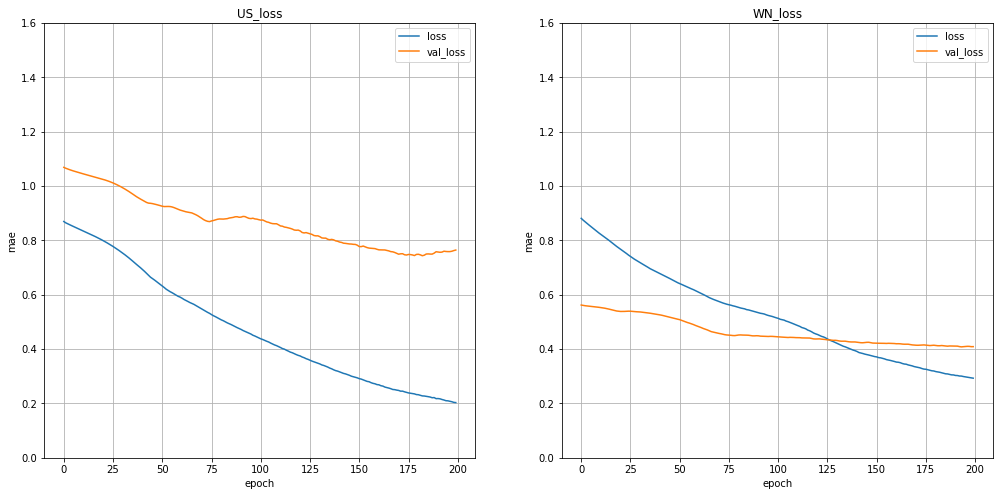

In [98]:
#show learning curves
#mean training loss measured over each epoch
#mean validation loss measured at the end of each epoch
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(17,8))
US_plot = pd.DataFrame(US_history.history) #selecting columns
WN_plot = pd.DataFrame(WN_history.history)
US_plot.plot(ax=axes[0],ylim=(0,1.6),title="US_loss",xlabel='epoch',ylabel='mae').grid(True)
WN_plot.plot(ax=axes[1],ylim=(0,1.6),title="WN_loss",xlabel='epoch',ylabel='mae').grid(True)
plt.savefig("plots/mae_6w_12w_1ts.png")

In [99]:
#create a model with the same architecture as the original model and then set its weights

"""
# To Re-evaluate the model
loss, acc = model_new.evaluate(x_test, y_test, verbose=2)
"""
def lstm_US(test_US):
    test_US=np.reshape(test_US, (1,-1))#reshape the data for scaling  
    test_US=US_x_scaler.transform(test_US)#scale the data
    test_US = test_US.reshape((test_US.shape[0],n_timesteps,test_US.shape[1]))#reshape the data for prediction
    input_shape=(n_timesteps,test_US.shape[2])
    US_model= create_lstm_model(input_shape)
    US_model.load_weights(US_checkpoint_path) # Loads the weights
    US_yhat=US_model.predict(test_US)
    US_yhat=np.reshape(US_yhat, (1,-1))
    inv_US_yhat=US_y_scaler.inverse_transform(US_yhat)
    inv_US_yhat=(inv_US_yhat[0][0],inv_US_yhat[0][1])
    result ={'at 6 weeks':inv_US_yhat[0],'at 12 weeks':inv_US_yhat[1]}
    return result

def lstm_WN(test_WN):
    test_WN=np.reshape(test_WN, (1,-1))
    test_WN=WN_x_scaler.transform(test_WN)
    test_WN = test_WN.reshape((test_WN.shape[0],n_timesteps,test_WN.shape[1]))
    input_shape=(n_timesteps,test_WN.shape[2])
    WN_model= create_lstm_model(input_shape)
    WN_model.load_weights(WN_checkpoint_path) # Loads the weights
    WN_yhat=WN_model.predict(test_WN)
    WN_yhat=np.reshape(WN_yhat, (1,-1))
    inv_WN_yhat=WN_y_scaler.inverse_transform(WN_yhat)
    inv_WN_yhat=(inv_WN_yhat[0][0],inv_WN_yhat[0][1])
    result ={'at 6 weeks':inv_WN_yhat[0],'at 12 weeks':inv_WN_yhat[1]}
    return result

#test model prediction
US_test=(5.0,8.0,3.0,2.0,100)
WN_test=(5.0,8.0,3.0,60.8)
US_yhat=lstm_US(US_test)
WN_yhat=lstm_WN(WN_test)

print(US_yhat)
print(WN_yhat)

/Users/manjuvallayil/miniforge3/envs/tinnitus/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
2022-05-15 06:16:08.059952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/manjuvallayil/miniforge3/envs/tinnitus/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


{'at 6 weeks': 71.59701, 'at 12 weeks': 99.487045}
{'at 6 weeks': 49.001892, 'at 12 weeks': 45.680187}


2022-05-15 06:16:08.212895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [100]:
def prediction(c_3,sl_1,sl_2,a_2,r_1,q_1,e_1,tfi):
    #append test inputs to df and save to csv
    x_test_new_df.loc[len(x_test_new_df)] = [c_3,sl_1,sl_2,a_2,r_1,q_1,e_1,tfi]
    x_test_new_df.to_csv('new_test_data_6w_12w_1ts.csv',index=False)
    #separate the features for US and WN
    test_US = (c_3,sl_1,a_2,q_1,tfi)
    test_WN = (sl_2,r_1,e_1,tfi)
    #make predictions
    US_yhat=lstm_US(test_US) # predict using the lstm model  .format(inv_US_yhat,text_1)
    WN_yhat=lstm_WN(test_WN) # predict using the lstm model
    loss_plot_path='plots/mae_6w_12w_1ts.png'
    return US_yhat, WN_yhat,loss_plot_path,pd.read_csv('new_test_data_6w_12w_1ts.csv')
    
import gradio as gr   # pip install gradio
iface = gr.Interface(
    prediction,
    inputs=[gr.inputs.Slider(minimum=1, maximum=10, step=0.5,label="c_3 / Your ability to FOCUS ATTENTION on other things besides your tinnitus?" ),
     gr.inputs.Slider(minimum=1, maximum=10, step=0.5,label="sl_1 / How often did your tinnitus make it difficult to FALL ASLEEP or STAY ASLEEP?" ),
     gr.inputs.Slider(minimum=1, maximum=10, step=0.5,label="sl_2 / How often did your tinnitus cause you difficulty in getting AS MUCH SLEEP as you needed?" ),
     gr.inputs.Slider(minimum=1, maximum=10, step=0.5,label="a_2 / Your ability to UNDERSTAND PEOPLE who are talking?" ),
     gr.inputs.Slider(minimum=1, maximum=10, step=0.5,label="r_1 / Your QUIET RESTING ACTIVITIES?" ),
     gr.inputs.Slider(minimum=1, maximum=10, step=0.5,label="q_1 / Your enjoyment of SOCIAL ACTIVITIES?" ),
     gr.inputs.Slider(minimum=1, maximum=10, step=0.5,label="e_1 / How ANXIOUS or WORRIED has your tinnitus made you feel?" ),
     gr.inputs.Number(label="baseline tfi (tfi_total_4w)", optional=False)],
    outputs=[gr.outputs.Textbox(label="US_therapy predicted TFI score"),gr.outputs.Textbox(label="WN_therapy predicted TFI score"),gr.outputs.Image(type="file", label="US and WN Models Training Loss Curves"),gr.outputs.Dataframe(label="Appending New test_data to a file")],
    allow_flagging="never",title="Mid & Post TFI_prediction",description="Please fill in all the fields and click Submit for the tfi_6w prediction"
)

iface.launch(share='TRUE')

Running on local URL:  http://127.0.0.1:7887/
Running on public URL: https://14295.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x177439ee0>,
 'http://127.0.0.1:7887/',
 'https://14295.gradio.app')

/Users/manjuvallayil/miniforge3/envs/tinnitus/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
2022-05-15 06:16:51.939380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/manjuvallayil/miniforge3/envs/tinnitus/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
2022-05-15 06:16:52.077889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
